# Annotate w1118_42D cells using FCA head/head+antenna pre-trained model

In [1]:
!python --version

Python 3.12.2


## Load required packages 

In [2]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import torch
import scvi
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
from scipy.sparse import csr_matrix
from scipy.stats import median_abs_deviation
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import gdown
import copy as cp
import os
import plotnine as p
import pickle

sns.set_style('white')
sns.set(font_scale=1.5)
sc.settings.set_figure_params(dpi=80, facecolor="white")
sc.logging.print_header()
sc.settings.verbosity = 3


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
 captum (see https://github.com/pytorch/captum).


scanpy==1.10.0 anndata==0.10.6 umap==0.5.5 numpy==1.26.4 scipy==1.12.0 pandas==2.2.1 scikit-learn==1.4.1.post1 statsmodels==0.14.1 igraph==0.11.4 pynndescent==0.5.12


In [3]:
print(os.getenv("CUDA_VISIBLE_DEVICES"))
os.environ["CUDA_VISIBLE_DEVICES"]=os.getenv("CUDA_VISIBLE_DEVICES")

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.current_device())
print(torch.cuda.device(0))
print(torch.cuda.get_device_name(0))

1
True
1
0
Tesla P100-PCIE-12GB


## Set up I/O and load pre-trained model and query data

In [4]:
## Set up I/O directories
basepath = Path("/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/")
referencepath = basepath.joinpath('reference','FCA')
inputpath = basepath.joinpath('analysis','preprocess')
outputpath = basepath.joinpath('analysis','scarches')

head_model = "/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/analysis/scarches/head_model/"
head_antenna_model = "/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/analysis/scarches/head_antenna_model/"

In [5]:
## Read pre-trained FCA head-model and cell type hierarchy 
head_latent = sc.read_h5ad(head_model+'reference_latent.h5ad')

with open(head_model+'tree_head_broadannotation_batch.pkl', 'rb') as tb: 
    tree_head_broadannotation_batch = pickle.load(tb)
tb.close()

with open(head_model+'mp_head_broadannotation_batch.pkl', 'rb') as mb: 
    mp_head_broadannotation_batch = pickle.load(mb) 
mb.close()

with open(head_model+'tree_head_fullannotation_batch.pkl', 'rb') as tf: 
    tree_head_fullannotation_batch = pickle.load(tf)
tf.close()

with open(head_model+'mp_head_fullannotation_batch.pkl', 'rb') as mf: 
    mp_head_fullannotation_batch = pickle.load(mf) 
mf.close()

with open(head_model+'hvgs.pkl', 'rb') as hvg: 
    fca_hvg = pickle.load(hvg)
hvg.close()

In [6]:
## Read pre-trained FCA head & antenna model and cell type hierarchy 
head_antenna_latent = sc.read_h5ad(head_antenna_model+'reference_latent.h5ad')

with open(head_antenna_model+'tree_combined_fullannotation_batch.pkl', 'rb') as tf: 
    tree_combined_fullannotation_batch = pickle.load(tf)
tf.close()

with open(head_antenna_model+'mp_combined_fullannotation_batch.pkl', 'rb') as mf: 
    mp_combined_fullannotation_batch = pickle.load(mf) 
mf.close()

In [7]:
## Read query w1118_42d data 
w1118_42d = sc.read_h5ad(inputpath.joinpath("w1118_42d_slim.h5ad"))
w1118_42d.raw = w1118_42d
w1118_42d

AnnData object with n_obs × n_vars = 9033 × 16507
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell_barcode', 'column_name', 'sample', 'sum', 'detected', 'percent.top_50', 'percent.top_100', 'percent.top_200', 'percent.top_500', 'total', 'doubletFinder_doublet_score_resolution_1.5', 'doubletFinder_doublet_label_resolution_1.5', 'scds_cxds_score', 'scds_cxds_call', 'scds_bcds_score', 'scds_bcds_call', 'scds_hybrid_score', 'scds_hybrid_call', 'decontX_contamination', 'decontX_clusters', 'nCount_decontXcounts', 'nFeature_decontXcounts', 'nCount_RNA', 'nFeature_RNA', 'log1p_total_counts', 'log1p_n_genes_by_counts', 'percent.mt', 'nCount_outlier', 'nFeature_outlier', 'mt_outlier', 'originalexp_snn_res.0.5', 'seurat_clusters', 'soup_group', 'nCount_soupXcounts', 'nFeature_soupXcounts', 'nCount_SCT', 'nFeature_SCT', 'nCount_soupX_SCT', 'nFeature_soupX_SCT', 'nCount_decontX_SCT', 'nFeature_decontX_SCT', 'SCT_snn_res.0.02', 'SCT_snn_res.0.2', 'SCT_snn_res.0.8', 'SCT_snn

In [31]:
## Read reference h5ad 
fca_reference_head = sc.read_h5ad(referencepath.joinpath("v2_fca_biohub_head_10x_raw.h5ad"))
fca_reference_head

AnnData object with n_obs × n_vars = 100527 × 13056
    obs: 'age', 'batch', 'batch_id', 'celda_decontx__clusters', 'celda_decontx__contamination', 'celda_decontx__doublemad_predicted_outliers', 'dissection_lab', 'fca_id', 'fly_genetics', 'id', 'log_n_counts', 'log_n_genes', 'n_counts', 'n_genes', 'note', 'percent_mito', 'sample_id', 'scrublet__doublet_scores', 'scrublet__predicted_doublets', 'scrublet__predicted_doublets_based_on_10x_chromium_spec', 'sex', 'tissue', 'leiden_res0.4', 'leiden_res0.6', 'leiden_res0.8', 'leiden_res1.0', 'leiden_res1.2', 'leiden_res1.4', 'leiden_res1.6', 'leiden_res1.8', 'leiden_res10.0', 'leiden_res12.0', 'leiden_res14.0', 'leiden_res16.0', 'leiden_res18.0', 'leiden_res2.0', 'leiden_res20.0', 'leiden_res25.0', 'leiden_res4.0', 'leiden_res50.0', 'leiden_res6.0', 'leiden_res8.0', 'annotation', 'broad_annotation', 'broad_annotation_extrapolated'
    obsm: 'X_pca', 'X_tsne', 'X_umap'

## Integrate w1118 with pretrained head model

In [8]:
w1118_42d = w1118_42d[:,fca_hvg]
w1118_42d

View of AnnData object with n_obs × n_vars = 9033 × 2000
    obs: 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell_barcode', 'column_name', 'sample', 'sum', 'detected', 'percent.top_50', 'percent.top_100', 'percent.top_200', 'percent.top_500', 'total', 'doubletFinder_doublet_score_resolution_1.5', 'doubletFinder_doublet_label_resolution_1.5', 'scds_cxds_score', 'scds_cxds_call', 'scds_bcds_score', 'scds_bcds_call', 'scds_hybrid_score', 'scds_hybrid_call', 'decontX_contamination', 'decontX_clusters', 'nCount_decontXcounts', 'nFeature_decontXcounts', 'nCount_RNA', 'nFeature_RNA', 'log1p_total_counts', 'log1p_n_genes_by_counts', 'percent.mt', 'nCount_outlier', 'nFeature_outlier', 'mt_outlier', 'originalexp_snn_res.0.5', 'seurat_clusters', 'soup_group', 'nCount_soupXcounts', 'nFeature_soupXcounts', 'nCount_SCT', 'nFeature_SCT', 'nCount_soupX_SCT', 'nFeature_soupX_SCT', 'nCount_decontX_SCT', 'nFeature_decontX_SCT', 'SCT_snn_res.0.02', 'SCT_snn_res.0.2', 'SCT_snn_res.0.8', '

In [20]:
w1118_42d = w1118_42d.copy()
w1118_42d.obs['batch'] = "0"
w1118_42d.obs['age'] = "42"
w1118_42d.obs['sex'] = "mixed"
w1118_42d.obs['fly_genotype'] = "w1118"
w1118_42d.obs['dissection_lab'] = "mccall"
w1118_42d.obs['tissue'] = "w1118_head"
w1118_42d.obs['tissue_batch'] = w1118_42d.obs['batch'].astype(str)+"_"+w1118_42d.obs['tissue'].astype(str)

w1118_42d.obs['batch'] = w1118_42d.obs['batch'].astype('category')
w1118_42d.obs['age'] = w1118_42d.obs['age'].astype('category')
w1118_42d.obs['fly_genotype'] = w1118_42d.obs['fly_genotype'].astype('category')
w1118_42d.obs['dissection_lab'] = w1118_42d.obs['dissection_lab'].astype('category')
w1118_42d.obs['tissue'] = w1118_42d.obs['tissue'].astype('category')
w1118_42d.obs['tissue_batch'] = w1118_42d.obs['tissue_batch'].astype('category')



w1118_42d_vae = sca.models.SCVI.load_query_data(
    w1118_42d,
    head_model,
    freeze_dropout = True)

INFO     File /projectnb/mccall/sbandyadka/drpr42d_snrnaseq/analysis/scarches/head_model/model.pt already          
         downloaded                                                                                                


/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/data/fields/_base_field.py:64: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?


In [21]:
w1118_42d.obs

,orig.ident,nCount_originalexp,nFeature_originalexp,cell_barcode,column_name,sample,sum,detected,percent.top_50,percent.top_100,...,decontX_SCT_snn_res.12,batch,age,sex,fly_genotype,dissection_lab,_scvi_batch,_scvi_labels,tissue,tissue_batch
w1118_42D_AAACCCAAGAGAGCAA-1,0,823.0,444,AAACCCAAGAGAGCAA-1,w1118_42D_AAACCCAAGAGAGCAA-1,w1118_42D,823.0,444,36.938032,52.247874,...,33,0,42,mixed,w1118,mccall,0,0,w1118_head,0_w1118_head
w1118_42D_AAACCCAAGCCGGATA-1,0,1138.0,686,AAACCCAAGCCGGATA-1,w1118_42D_AAACCCAAGCCGGATA-1,w1118_42D,1138.0,686,25.834798,38.664323,...,39,0,42,mixed,w1118,mccall,0,0,w1118_head,0_w1118_head
w1118_42D_AAACCCACATAATGCC-1,0,1573.0,809,AAACCCACATAATGCC-1,w1118_42D_AAACCCACATAATGCC-1,w1118_42D,1573.0,809,25.874126,38.270820,...,9,0,42,mixed,w1118,mccall,0,0,w1118_head,0_w1118_head
w1118_42D_AAACCCAGTACTCAAC-1,0,2398.0,799,AAACCCAGTACTCAAC-1,w1118_42D_AAACCCAGTACTCAAC-1,w1118_42D,2398.0,799,47.122602,57.714762,...,29,0,42,mixed,w1118,mccall,0,0,w1118_head,0_w1118_head
w1118_42D_AAACCCATCAAGGCTT-1,0,693.0,427,AAACCCATCAAGGCTT-1,w1118_42D_AAACCCATCAAGGCTT-1,w1118_42D,693.0,427,35.209235,49.639250,...,35,0,42,mixed,w1118,mccall,0,0,w1118_head,0_w1118_head
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
w1118_42D_TTTGTTGGTCGAACAG-1,0,795.0,484,TTTGTTGGTCGAACAG-1,w1118_42D_TTTGTTGGTCGAACAG-1,w1118_42D,795.0,484,31.572327,45.534591,...,6,0,42,mixed,w1118,mccall,0,0,w1118_head,0_w1118_head
w1118_42D_TTTGTTGGTGATAGTA-1,0,867.0,522,TTTGTTGGTGATAGTA-1,w1118_42D_TTTGTTGGTGATAGTA-1,w1118_42D,867.0,522,30.219146,44.059977,...,40,0,42,mixed,w1118,mccall,0,0,w1118_head,0_w1118_head
w1118_42D_TTTGTTGGTTCAAGGG-1,0,575.0,331,TTTGTTGGTTCAAGGG-1,w1118_42D_TTTGTTGGTTCAAGGG-1,w1118_42D,575.0,331,43.652174,59.826087,...,53,0,42,mixed,w1118,mccall,0,0,w1118_head,0_w1118_head
w1118_42D_TTTGTTGTCGAGTTGT-1,0,681.0,432,TTTGTTGTCGAGTTGT-1,w1118_42D_TTTGTTGTCGAGTTGT-1,w1118_42D,681.0,432,31.424376,47.136564,...,25,0,42,mixed,w1118,mccall,0,0,w1118_head,0_w1118_head


In [24]:
w1118_42d_vae.train(max_epochs=500, check_val_every_n_epoch = 1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Epoch 1/500:   0%|          | 0/500 [00:00<?, ?it/s]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 2/500:   0%|          | 1/500 [00:00<06:42,  1.24it/s, v_num=1, train_loss_step=579, train_loss_epoch=571]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 3/500:   0%|          | 2/500 [00:01<06:39,  1.25it/s, v_num=1, train_loss_step=584, train_loss_epoch=571]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 4/500:   1%|          | 3/500 [00:02<06:38,  1.25it/s, v_num=1, train_loss_step=567, train_loss_epoch=571]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 5/500:   1%|          | 4/500 [00:03<06:38,  1.25it/s, v_num=1, train_loss_step=577, train_loss_epoch=571]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 6/500:   1%|          | 5/500 [00:04<06:37,  1.25it/s, v_num=1, train_loss_step=560, train_loss_epoch=571]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 7/500:   1%|          | 6/500 [00:04<06:36,  1.25it/s, v_num=1, train_loss_step=568, train_loss_epoch=571]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 8/500:   1%|▏         | 7/500 [00:05<06:35,  1.25it/s, v_num=1, train_loss_step=563, train_loss_epoch=571]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 9/500:   2%|▏         | 8/500 [00:06<06:34,  1.25it/s, v_num=1, train_loss_step=582, train_loss_epoch=571]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 10/500:   2%|▏         | 9/500 [00:07<06:34,  1.25it/s, v_num=1, train_loss_step=569, train_loss_epoch=571]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 11/500:   2%|▏         | 10/500 [00:08<06:33,  1.25it/s, v_num=1, train_loss_step=591, train_loss_epoch=571]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 12/500:   2%|▏         | 11/500 [00:08<06:31,  1.25it/s, v_num=1, train_loss_step=577, train_loss_epoch=571]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 13/500:   2%|▏         | 12/500 [00:09<06:30,  1.25it/s, v_num=1, train_loss_step=558, train_loss_epoch=571]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 14/500:   3%|▎         | 13/500 [00:10<06:29,  1.25it/s, v_num=1, train_loss_step=581, train_loss_epoch=571]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 15/500:   3%|▎         | 14/500 [00:11<06:29,  1.25it/s, v_num=1, train_loss_step=557, train_loss_epoch=571]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 16/500:   3%|▎         | 15/500 [00:12<06:28,  1.25it/s, v_num=1, train_loss_step=557, train_loss_epoch=571]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 17/500:   3%|▎         | 16/500 [00:12<06:26,  1.25it/s, v_num=1, train_loss_step=574, train_loss_epoch=571]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 18/500:   3%|▎         | 17/500 [00:13<06:26,  1.25it/s, v_num=1, train_loss_step=567, train_loss_epoch=571]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 19/500:   4%|▎         | 18/500 [00:14<06:26,  1.25it/s, v_num=1, train_loss_step=569, train_loss_epoch=571]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 20/500:   4%|▍         | 19/500 [00:15<06:25,  1.25it/s, v_num=1, train_loss_step=581, train_loss_epoch=571]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 21/500:   4%|▍         | 20/500 [00:16<06:24,  1.25it/s, v_num=1, train_loss_step=578, train_loss_epoch=572]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 22/500:   4%|▍         | 21/500 [00:16<06:24,  1.25it/s, v_num=1, train_loss_step=564, train_loss_epoch=572]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 23/500:   4%|▍         | 22/500 [00:17<06:23,  1.25it/s, v_num=1, train_loss_step=572, train_loss_epoch=572]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 24/500:   5%|▍         | 23/500 [00:18<06:22,  1.25it/s, v_num=1, train_loss_step=572, train_loss_epoch=572]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 25/500:   5%|▍         | 24/500 [00:19<06:21,  1.25it/s, v_num=1, train_loss_step=571, train_loss_epoch=572]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 26/500:   5%|▌         | 25/500 [00:20<06:20,  1.25it/s, v_num=1, train_loss_step=546, train_loss_epoch=572]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 27/500:   5%|▌         | 26/500 [00:20<06:20,  1.25it/s, v_num=1, train_loss_step=570, train_loss_epoch=572]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 28/500:   5%|▌         | 27/500 [00:21<06:19,  1.25it/s, v_num=1, train_loss_step=567, train_loss_epoch=572]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 29/500:   6%|▌         | 28/500 [00:22<06:18,  1.25it/s, v_num=1, train_loss_step=574, train_loss_epoch=572]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 30/500:   6%|▌         | 29/500 [00:23<06:18,  1.24it/s, v_num=1, train_loss_step=571, train_loss_epoch=572]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 31/500:   6%|▌         | 30/500 [00:24<06:16,  1.25it/s, v_num=1, train_loss_step=566, train_loss_epoch=572]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 32/500:   6%|▌         | 31/500 [00:24<06:15,  1.25it/s, v_num=1, train_loss_step=572, train_loss_epoch=572]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 33/500:   6%|▋         | 32/500 [00:25<06:15,  1.25it/s, v_num=1, train_loss_step=589, train_loss_epoch=572]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 34/500:   7%|▋         | 33/500 [00:26<06:14,  1.25it/s, v_num=1, train_loss_step=563, train_loss_epoch=572]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 35/500:   7%|▋         | 34/500 [00:27<06:13,  1.25it/s, v_num=1, train_loss_step=574, train_loss_epoch=572]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 36/500:   7%|▋         | 35/500 [00:28<06:13,  1.25it/s, v_num=1, train_loss_step=552, train_loss_epoch=572]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 37/500:   7%|▋         | 36/500 [00:28<06:11,  1.25it/s, v_num=1, train_loss_step=582, train_loss_epoch=572]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 38/500:   7%|▋         | 37/500 [00:29<06:11,  1.25it/s, v_num=1, train_loss_step=570, train_loss_epoch=572]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 39/500:   8%|▊         | 38/500 [00:30<06:10,  1.25it/s, v_num=1, train_loss_step=559, train_loss_epoch=572]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 40/500:   8%|▊         | 39/500 [00:31<06:09,  1.25it/s, v_num=1, train_loss_step=571, train_loss_epoch=572]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 41/500:   8%|▊         | 40/500 [00:32<06:08,  1.25it/s, v_num=1, train_loss_step=560, train_loss_epoch=572]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 42/500:   8%|▊         | 41/500 [00:32<06:07,  1.25it/s, v_num=1, train_loss_step=581, train_loss_epoch=573]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 43/500:   8%|▊         | 42/500 [00:33<06:06,  1.25it/s, v_num=1, train_loss_step=584, train_loss_epoch=573]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 44/500:   9%|▊         | 43/500 [00:34<06:06,  1.25it/s, v_num=1, train_loss_step=571, train_loss_epoch=573]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 45/500:   9%|▉         | 44/500 [00:35<06:06,  1.24it/s, v_num=1, train_loss_step=579, train_loss_epoch=573]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 46/500:   9%|▉         | 45/500 [00:36<06:05,  1.24it/s, v_num=1, train_loss_step=555, train_loss_epoch=573]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 47/500:   9%|▉         | 46/500 [00:36<06:04,  1.25it/s, v_num=1, train_loss_step=571, train_loss_epoch=573]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 48/500:   9%|▉         | 47/500 [00:37<06:06,  1.24it/s, v_num=1, train_loss_step=573, train_loss_epoch=573]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 49/500:  10%|▉         | 48/500 [00:38<06:03,  1.24it/s, v_num=1, train_loss_step=568, train_loss_epoch=573]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 50/500:  10%|▉         | 49/500 [00:39<06:02,  1.25it/s, v_num=1, train_loss_step=568, train_loss_epoch=573]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 51/500:  10%|█         | 50/500 [00:40<06:00,  1.25it/s, v_num=1, train_loss_step=573, train_loss_epoch=573]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 52/500:  10%|█         | 51/500 [00:40<05:59,  1.25it/s, v_num=1, train_loss_step=600, train_loss_epoch=573]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 53/500:  10%|█         | 52/500 [00:41<05:59,  1.25it/s, v_num=1, train_loss_step=569, train_loss_epoch=573]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 54/500:  11%|█         | 53/500 [00:42<05:58,  1.25it/s, v_num=1, train_loss_step=582, train_loss_epoch=573]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 55/500:  11%|█         | 54/500 [00:43<05:56,  1.25it/s, v_num=1, train_loss_step=558, train_loss_epoch=573]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 56/500:  11%|█         | 55/500 [00:44<05:55,  1.25it/s, v_num=1, train_loss_step=577, train_loss_epoch=573]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 57/500:  11%|█         | 56/500 [00:44<05:54,  1.25it/s, v_num=1, train_loss_step=577, train_loss_epoch=573]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 58/500:  11%|█▏        | 57/500 [00:45<05:53,  1.25it/s, v_num=1, train_loss_step=559, train_loss_epoch=573]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 59/500:  12%|█▏        | 58/500 [00:46<05:53,  1.25it/s, v_num=1, train_loss_step=582, train_loss_epoch=573]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 60/500:  12%|█▏        | 59/500 [00:47<05:52,  1.25it/s, v_num=1, train_loss_step=575, train_loss_epoch=573]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 61/500:  12%|█▏        | 60/500 [00:48<05:52,  1.25it/s, v_num=1, train_loss_step=580, train_loss_epoch=573]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 62/500:  12%|█▏        | 61/500 [00:48<05:51,  1.25it/s, v_num=1, train_loss_step=586, train_loss_epoch=573]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 63/500:  12%|█▏        | 62/500 [00:49<05:50,  1.25it/s, v_num=1, train_loss_step=593, train_loss_epoch=573]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 64/500:  13%|█▎        | 63/500 [00:50<05:49,  1.25it/s, v_num=1, train_loss_step=553, train_loss_epoch=574]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 65/500:  13%|█▎        | 64/500 [00:51<05:48,  1.25it/s, v_num=1, train_loss_step=570, train_loss_epoch=574]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 66/500:  13%|█▎        | 65/500 [00:52<05:47,  1.25it/s, v_num=1, train_loss_step=570, train_loss_epoch=574]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 67/500:  13%|█▎        | 66/500 [00:52<05:47,  1.25it/s, v_num=1, train_loss_step=562, train_loss_epoch=574]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 68/500:  13%|█▎        | 67/500 [00:53<05:45,  1.25it/s, v_num=1, train_loss_step=577, train_loss_epoch=574]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 69/500:  14%|█▎        | 68/500 [00:54<05:45,  1.25it/s, v_num=1, train_loss_step=575, train_loss_epoch=574]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 70/500:  14%|█▍        | 69/500 [00:55<05:45,  1.25it/s, v_num=1, train_loss_step=568, train_loss_epoch=574]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 71/500:  14%|█▍        | 70/500 [00:56<05:45,  1.25it/s, v_num=1, train_loss_step=549, train_loss_epoch=574]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 72/500:  14%|█▍        | 71/500 [00:56<05:43,  1.25it/s, v_num=1, train_loss_step=578, train_loss_epoch=574]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 73/500:  14%|█▍        | 72/500 [00:57<05:43,  1.24it/s, v_num=1, train_loss_step=575, train_loss_epoch=574]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 74/500:  15%|█▍        | 73/500 [00:58<05:42,  1.25it/s, v_num=1, train_loss_step=583, train_loss_epoch=574]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 75/500:  15%|█▍        | 74/500 [00:59<05:40,  1.25it/s, v_num=1, train_loss_step=563, train_loss_epoch=574]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 76/500:  15%|█▌        | 75/500 [01:00<05:40,  1.25it/s, v_num=1, train_loss_step=581, train_loss_epoch=574]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 77/500:  15%|█▌        | 76/500 [01:00<05:38,  1.25it/s, v_num=1, train_loss_step=567, train_loss_epoch=574]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 78/500:  15%|█▌        | 77/500 [01:01<05:37,  1.25it/s, v_num=1, train_loss_step=564, train_loss_epoch=574]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 79/500:  16%|█▌        | 78/500 [01:02<05:37,  1.25it/s, v_num=1, train_loss_step=579, train_loss_epoch=574]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 80/500:  16%|█▌        | 79/500 [01:03<05:36,  1.25it/s, v_num=1, train_loss_step=563, train_loss_epoch=574]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 81/500:  16%|█▌        | 80/500 [01:04<05:37,  1.24it/s, v_num=1, train_loss_step=590, train_loss_epoch=574]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 82/500:  16%|█▌        | 81/500 [01:04<05:36,  1.25it/s, v_num=1, train_loss_step=580, train_loss_epoch=574]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 83/500:  16%|█▋        | 82/500 [01:05<05:34,  1.25it/s, v_num=1, train_loss_step=584, train_loss_epoch=574]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 84/500:  17%|█▋        | 83/500 [01:06<05:34,  1.25it/s, v_num=1, train_loss_step=601, train_loss_epoch=574]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 85/500:  17%|█▋        | 84/500 [01:07<05:33,  1.25it/s, v_num=1, train_loss_step=564, train_loss_epoch=574]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 86/500:  17%|█▋        | 85/500 [01:08<05:31,  1.25it/s, v_num=1, train_loss_step=583, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 87/500:  17%|█▋        | 86/500 [01:08<05:31,  1.25it/s, v_num=1, train_loss_step=578, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 88/500:  17%|█▋        | 87/500 [01:09<05:30,  1.25it/s, v_num=1, train_loss_step=591, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 89/500:  18%|█▊        | 88/500 [01:10<05:29,  1.25it/s, v_num=1, train_loss_step=558, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 90/500:  18%|█▊        | 89/500 [01:11<05:28,  1.25it/s, v_num=1, train_loss_step=579, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 91/500:  18%|█▊        | 90/500 [01:12<05:28,  1.25it/s, v_num=1, train_loss_step=568, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 92/500:  18%|█▊        | 91/500 [01:12<05:27,  1.25it/s, v_num=1, train_loss_step=567, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 93/500:  18%|█▊        | 92/500 [01:13<05:27,  1.25it/s, v_num=1, train_loss_step=572, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 94/500:  19%|█▊        | 93/500 [01:14<05:25,  1.25it/s, v_num=1, train_loss_step=567, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 95/500:  19%|█▉        | 94/500 [01:15<05:24,  1.25it/s, v_num=1, train_loss_step=580, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 96/500:  19%|█▉        | 95/500 [01:16<05:24,  1.25it/s, v_num=1, train_loss_step=578, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 97/500:  19%|█▉        | 96/500 [01:16<05:24,  1.25it/s, v_num=1, train_loss_step=583, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 98/500:  19%|█▉        | 97/500 [01:17<05:23,  1.25it/s, v_num=1, train_loss_step=576, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 99/500:  20%|█▉        | 98/500 [01:18<05:21,  1.25it/s, v_num=1, train_loss_step=582, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 100/500:  20%|█▉        | 99/500 [01:19<05:20,  1.25it/s, v_num=1, train_loss_step=589, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 101/500:  20%|██        | 100/500 [01:20<05:19,  1.25it/s, v_num=1, train_loss_step=570, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 102/500:  20%|██        | 101/500 [01:20<05:18,  1.25it/s, v_num=1, train_loss_step=593, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 103/500:  20%|██        | 102/500 [01:21<05:17,  1.25it/s, v_num=1, train_loss_step=592, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 104/500:  21%|██        | 103/500 [01:22<05:17,  1.25it/s, v_num=1, train_loss_step=586, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 105/500:  21%|██        | 104/500 [01:23<05:16,  1.25it/s, v_num=1, train_loss_step=568, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 106/500:  21%|██        | 105/500 [01:24<05:15,  1.25it/s, v_num=1, train_loss_step=579, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 107/500:  21%|██        | 106/500 [01:24<05:15,  1.25it/s, v_num=1, train_loss_step=584, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 108/500:  21%|██▏       | 107/500 [01:25<05:14,  1.25it/s, v_num=1, train_loss_step=580, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 109/500:  22%|██▏       | 108/500 [01:26<05:13,  1.25it/s, v_num=1, train_loss_step=581, train_loss_epoch=575]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 110/500:  22%|██▏       | 109/500 [01:27<05:13,  1.25it/s, v_num=1, train_loss_step=571, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 111/500:  22%|██▏       | 110/500 [01:28<05:12,  1.25it/s, v_num=1, train_loss_step=560, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 112/500:  22%|██▏       | 111/500 [01:28<05:11,  1.25it/s, v_num=1, train_loss_step=570, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 113/500:  22%|██▏       | 112/500 [01:29<05:10,  1.25it/s, v_num=1, train_loss_step=567, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 114/500:  23%|██▎       | 113/500 [01:30<05:09,  1.25it/s, v_num=1, train_loss_step=571, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 115/500:  23%|██▎       | 114/500 [01:31<05:08,  1.25it/s, v_num=1, train_loss_step=567, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 116/500:  23%|██▎       | 115/500 [01:32<05:07,  1.25it/s, v_num=1, train_loss_step=567, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 117/500:  23%|██▎       | 116/500 [01:32<05:07,  1.25it/s, v_num=1, train_loss_step=569, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 118/500:  23%|██▎       | 117/500 [01:33<05:06,  1.25it/s, v_num=1, train_loss_step=578, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 119/500:  24%|██▎       | 118/500 [01:34<05:06,  1.25it/s, v_num=1, train_loss_step=584, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 120/500:  24%|██▍       | 119/500 [01:35<05:05,  1.25it/s, v_num=1, train_loss_step=571, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 121/500:  24%|██▍       | 120/500 [01:36<05:04,  1.25it/s, v_num=1, train_loss_step=573, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 122/500:  24%|██▍       | 121/500 [01:36<05:03,  1.25it/s, v_num=1, train_loss_step=575, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 123/500:  24%|██▍       | 122/500 [01:37<05:02,  1.25it/s, v_num=1, train_loss_step=572, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 124/500:  25%|██▍       | 123/500 [01:38<05:02,  1.25it/s, v_num=1, train_loss_step=573, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 125/500:  25%|██▍       | 124/500 [01:39<05:00,  1.25it/s, v_num=1, train_loss_step=580, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 126/500:  25%|██▌       | 125/500 [01:40<04:59,  1.25it/s, v_num=1, train_loss_step=593, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 127/500:  25%|██▌       | 126/500 [01:40<04:58,  1.25it/s, v_num=1, train_loss_step=562, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 128/500:  25%|██▌       | 127/500 [01:41<04:58,  1.25it/s, v_num=1, train_loss_step=569, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 129/500:  26%|██▌       | 128/500 [01:42<04:57,  1.25it/s, v_num=1, train_loss_step=581, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 130/500:  26%|██▌       | 129/500 [01:43<04:57,  1.25it/s, v_num=1, train_loss_step=565, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 131/500:  26%|██▌       | 130/500 [01:44<04:56,  1.25it/s, v_num=1, train_loss_step=585, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 132/500:  26%|██▌       | 131/500 [01:44<04:55,  1.25it/s, v_num=1, train_loss_step=557, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 133/500:  26%|██▋       | 132/500 [01:45<04:55,  1.25it/s, v_num=1, train_loss_step=586, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 134/500:  27%|██▋       | 133/500 [01:46<04:54,  1.25it/s, v_num=1, train_loss_step=580, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 135/500:  27%|██▋       | 134/500 [01:47<04:53,  1.25it/s, v_num=1, train_loss_step=583, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 136/500:  27%|██▋       | 135/500 [01:48<04:52,  1.25it/s, v_num=1, train_loss_step=567, train_loss_epoch=576]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 137/500:  27%|██▋       | 136/500 [01:48<04:51,  1.25it/s, v_num=1, train_loss_step=591, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 138/500:  27%|██▋       | 137/500 [01:49<04:51,  1.25it/s, v_num=1, train_loss_step=567, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 139/500:  28%|██▊       | 138/500 [01:50<04:50,  1.24it/s, v_num=1, train_loss_step=584, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 140/500:  28%|██▊       | 139/500 [01:51<04:49,  1.25it/s, v_num=1, train_loss_step=581, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 141/500:  28%|██▊       | 140/500 [01:52<04:48,  1.25it/s, v_num=1, train_loss_step=578, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 142/500:  28%|██▊       | 141/500 [01:52<04:47,  1.25it/s, v_num=1, train_loss_step=560, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 143/500:  28%|██▊       | 142/500 [01:53<04:46,  1.25it/s, v_num=1, train_loss_step=594, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 144/500:  29%|██▊       | 143/500 [01:54<04:46,  1.25it/s, v_num=1, train_loss_step=565, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 145/500:  29%|██▉       | 144/500 [01:55<04:45,  1.25it/s, v_num=1, train_loss_step=569, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 146/500:  29%|██▉       | 145/500 [01:56<04:42,  1.25it/s, v_num=1, train_loss_step=589, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 147/500:  29%|██▉       | 146/500 [01:56<04:42,  1.25it/s, v_num=1, train_loss_step=571, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 148/500:  29%|██▉       | 147/500 [01:57<04:41,  1.25it/s, v_num=1, train_loss_step=591, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 149/500:  30%|██▉       | 148/500 [01:58<04:40,  1.25it/s, v_num=1, train_loss_step=565, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 150/500:  30%|██▉       | 149/500 [01:59<04:39,  1.25it/s, v_num=1, train_loss_step=562, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 151/500:  30%|███       | 150/500 [02:00<04:39,  1.25it/s, v_num=1, train_loss_step=574, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 152/500:  30%|███       | 151/500 [02:00<04:38,  1.25it/s, v_num=1, train_loss_step=584, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 153/500:  30%|███       | 152/500 [02:01<04:37,  1.25it/s, v_num=1, train_loss_step=593, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 154/500:  31%|███       | 153/500 [02:02<04:37,  1.25it/s, v_num=1, train_loss_step=572, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 155/500:  31%|███       | 154/500 [02:03<04:36,  1.25it/s, v_num=1, train_loss_step=578, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 156/500:  31%|███       | 155/500 [02:04<04:35,  1.25it/s, v_num=1, train_loss_step=567, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 157/500:  31%|███       | 156/500 [02:04<04:34,  1.25it/s, v_num=1, train_loss_step=580, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 158/500:  31%|███▏      | 157/500 [02:05<04:34,  1.25it/s, v_num=1, train_loss_step=596, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 159/500:  32%|███▏      | 158/500 [02:06<04:33,  1.25it/s, v_num=1, train_loss_step=579, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 160/500:  32%|███▏      | 159/500 [02:07<04:32,  1.25it/s, v_num=1, train_loss_step=575, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 161/500:  32%|███▏      | 160/500 [02:08<04:31,  1.25it/s, v_num=1, train_loss_step=584, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 162/500:  32%|███▏      | 161/500 [02:08<04:30,  1.25it/s, v_num=1, train_loss_step=572, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 163/500:  32%|███▏      | 162/500 [02:09<04:29,  1.25it/s, v_num=1, train_loss_step=572, train_loss_epoch=577]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 164/500:  33%|███▎      | 163/500 [02:10<04:29,  1.25it/s, v_num=1, train_loss_step=582, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 165/500:  33%|███▎      | 164/500 [02:11<04:28,  1.25it/s, v_num=1, train_loss_step=560, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 166/500:  33%|███▎      | 165/500 [02:12<04:27,  1.25it/s, v_num=1, train_loss_step=580, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 167/500:  33%|███▎      | 166/500 [02:12<04:26,  1.25it/s, v_num=1, train_loss_step=589, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 168/500:  33%|███▎      | 167/500 [02:13<04:25,  1.25it/s, v_num=1, train_loss_step=597, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 169/500:  34%|███▎      | 168/500 [02:14<04:25,  1.25it/s, v_num=1, train_loss_step=567, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 170/500:  34%|███▍      | 169/500 [02:15<04:24,  1.25it/s, v_num=1, train_loss_step=575, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 171/500:  34%|███▍      | 170/500 [02:16<04:23,  1.25it/s, v_num=1, train_loss_step=565, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 172/500:  34%|███▍      | 171/500 [02:16<04:21,  1.26it/s, v_num=1, train_loss_step=584, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 173/500:  34%|███▍      | 172/500 [02:17<04:20,  1.26it/s, v_num=1, train_loss_step=578, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 174/500:  35%|███▍      | 173/500 [02:18<04:19,  1.26it/s, v_num=1, train_loss_step=580, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 175/500:  35%|███▍      | 174/500 [02:19<04:18,  1.26it/s, v_num=1, train_loss_step=581, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 176/500:  35%|███▌      | 175/500 [02:20<04:17,  1.26it/s, v_num=1, train_loss_step=588, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 177/500:  35%|███▌      | 176/500 [02:20<04:16,  1.26it/s, v_num=1, train_loss_step=601, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 178/500:  35%|███▌      | 177/500 [02:21<04:15,  1.26it/s, v_num=1, train_loss_step=572, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 179/500:  36%|███▌      | 178/500 [02:22<04:15,  1.26it/s, v_num=1, train_loss_step=568, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 180/500:  36%|███▌      | 179/500 [02:23<04:13,  1.26it/s, v_num=1, train_loss_step=589, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 181/500:  36%|███▌      | 180/500 [02:24<04:13,  1.26it/s, v_num=1, train_loss_step=570, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 182/500:  36%|███▌      | 181/500 [02:24<04:12,  1.26it/s, v_num=1, train_loss_step=588, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 183/500:  36%|███▋      | 182/500 [02:25<04:11,  1.26it/s, v_num=1, train_loss_step=556, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 184/500:  37%|███▋      | 183/500 [02:26<04:11,  1.26it/s, v_num=1, train_loss_step=586, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 185/500:  37%|███▋      | 184/500 [02:27<04:10,  1.26it/s, v_num=1, train_loss_step=596, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 186/500:  37%|███▋      | 185/500 [02:27<04:09,  1.26it/s, v_num=1, train_loss_step=602, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 187/500:  37%|███▋      | 186/500 [02:28<04:09,  1.26it/s, v_num=1, train_loss_step=584, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 188/500:  37%|███▋      | 187/500 [02:29<04:08,  1.26it/s, v_num=1, train_loss_step=570, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 189/500:  38%|███▊      | 188/500 [02:30<04:07,  1.26it/s, v_num=1, train_loss_step=577, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 190/500:  38%|███▊      | 189/500 [02:31<04:06,  1.26it/s, v_num=1, train_loss_step=581, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 191/500:  38%|███▊      | 190/500 [02:31<04:06,  1.26it/s, v_num=1, train_loss_step=582, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 192/500:  38%|███▊      | 191/500 [02:32<04:04,  1.26it/s, v_num=1, train_loss_step=567, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 193/500:  38%|███▊      | 192/500 [02:33<04:05,  1.26it/s, v_num=1, train_loss_step=589, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 194/500:  39%|███▊      | 193/500 [02:34<04:04,  1.26it/s, v_num=1, train_loss_step=565, train_loss_epoch=578]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 195/500:  39%|███▉      | 194/500 [02:35<04:02,  1.26it/s, v_num=1, train_loss_step=571, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 196/500:  39%|███▉      | 195/500 [02:35<04:01,  1.26it/s, v_num=1, train_loss_step=577, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 197/500:  39%|███▉      | 196/500 [02:36<04:01,  1.26it/s, v_num=1, train_loss_step=587, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 198/500:  39%|███▉      | 197/500 [02:37<04:00,  1.26it/s, v_num=1, train_loss_step=575, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 199/500:  40%|███▉      | 198/500 [02:38<03:59,  1.26it/s, v_num=1, train_loss_step=587, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 200/500:  40%|███▉      | 199/500 [02:39<03:58,  1.26it/s, v_num=1, train_loss_step=584, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 201/500:  40%|████      | 200/500 [02:39<03:58,  1.26it/s, v_num=1, train_loss_step=569, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 202/500:  40%|████      | 201/500 [02:40<03:57,  1.26it/s, v_num=1, train_loss_step=566, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 203/500:  40%|████      | 202/500 [02:41<03:56,  1.26it/s, v_num=1, train_loss_step=587, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 204/500:  41%|████      | 203/500 [02:42<03:55,  1.26it/s, v_num=1, train_loss_step=570, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 205/500:  41%|████      | 204/500 [02:43<03:55,  1.26it/s, v_num=1, train_loss_step=575, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 206/500:  41%|████      | 205/500 [02:43<03:53,  1.26it/s, v_num=1, train_loss_step=597, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 207/500:  41%|████      | 206/500 [02:44<03:53,  1.26it/s, v_num=1, train_loss_step=580, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 208/500:  41%|████▏     | 207/500 [02:45<03:52,  1.26it/s, v_num=1, train_loss_step=582, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 209/500:  42%|████▏     | 208/500 [02:46<03:51,  1.26it/s, v_num=1, train_loss_step=579, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 210/500:  42%|████▏     | 209/500 [02:47<03:50,  1.26it/s, v_num=1, train_loss_step=595, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 211/500:  42%|████▏     | 210/500 [02:47<03:50,  1.26it/s, v_num=1, train_loss_step=585, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 212/500:  42%|████▏     | 211/500 [02:48<03:49,  1.26it/s, v_num=1, train_loss_step=580, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 213/500:  42%|████▏     | 212/500 [02:49<03:48,  1.26it/s, v_num=1, train_loss_step=582, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 214/500:  43%|████▎     | 213/500 [02:50<03:47,  1.26it/s, v_num=1, train_loss_step=572, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 215/500:  43%|████▎     | 214/500 [02:51<03:47,  1.26it/s, v_num=1, train_loss_step=564, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 216/500:  43%|████▎     | 215/500 [02:51<03:46,  1.26it/s, v_num=1, train_loss_step=570, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 217/500:  43%|████▎     | 216/500 [02:52<03:46,  1.26it/s, v_num=1, train_loss_step=579, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 218/500:  43%|████▎     | 217/500 [02:53<03:45,  1.25it/s, v_num=1, train_loss_step=586, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 219/500:  44%|████▎     | 218/500 [02:54<03:44,  1.26it/s, v_num=1, train_loss_step=584, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 220/500:  44%|████▍     | 219/500 [02:55<03:43,  1.26it/s, v_num=1, train_loss_step=569, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 221/500:  44%|████▍     | 220/500 [02:55<03:42,  1.26it/s, v_num=1, train_loss_step=576, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 222/500:  44%|████▍     | 221/500 [02:56<03:42,  1.26it/s, v_num=1, train_loss_step=577, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 223/500:  44%|████▍     | 222/500 [02:57<03:40,  1.26it/s, v_num=1, train_loss_step=578, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 224/500:  45%|████▍     | 223/500 [02:58<03:40,  1.26it/s, v_num=1, train_loss_step=573, train_loss_epoch=579]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 225/500:  45%|████▍     | 224/500 [02:58<03:39,  1.26it/s, v_num=1, train_loss_step=584, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 226/500:  45%|████▌     | 225/500 [02:59<03:38,  1.26it/s, v_num=1, train_loss_step=581, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 227/500:  45%|████▌     | 226/500 [03:00<03:37,  1.26it/s, v_num=1, train_loss_step=586, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 228/500:  45%|████▌     | 227/500 [03:01<03:37,  1.26it/s, v_num=1, train_loss_step=561, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 229/500:  46%|████▌     | 228/500 [03:02<03:35,  1.26it/s, v_num=1, train_loss_step=584, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 230/500:  46%|████▌     | 229/500 [03:02<03:35,  1.26it/s, v_num=1, train_loss_step=600, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 231/500:  46%|████▌     | 230/500 [03:03<03:34,  1.26it/s, v_num=1, train_loss_step=585, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 232/500:  46%|████▌     | 231/500 [03:04<03:33,  1.26it/s, v_num=1, train_loss_step=587, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 233/500:  46%|████▋     | 232/500 [03:05<03:32,  1.26it/s, v_num=1, train_loss_step=576, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 234/500:  47%|████▋     | 233/500 [03:06<03:32,  1.26it/s, v_num=1, train_loss_step=589, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 235/500:  47%|████▋     | 234/500 [03:06<03:31,  1.26it/s, v_num=1, train_loss_step=591, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 236/500:  47%|████▋     | 235/500 [03:07<03:30,  1.26it/s, v_num=1, train_loss_step=590, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 237/500:  47%|████▋     | 236/500 [03:08<03:29,  1.26it/s, v_num=1, train_loss_step=571, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 238/500:  47%|████▋     | 237/500 [03:09<03:28,  1.26it/s, v_num=1, train_loss_step=575, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 239/500:  48%|████▊     | 238/500 [03:10<03:27,  1.26it/s, v_num=1, train_loss_step=560, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 240/500:  48%|████▊     | 239/500 [03:10<03:26,  1.26it/s, v_num=1, train_loss_step=595, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 241/500:  48%|████▊     | 240/500 [03:11<03:26,  1.26it/s, v_num=1, train_loss_step=568, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 242/500:  48%|████▊     | 241/500 [03:12<03:25,  1.26it/s, v_num=1, train_loss_step=580, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 243/500:  48%|████▊     | 242/500 [03:13<03:24,  1.26it/s, v_num=1, train_loss_step=574, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 244/500:  49%|████▊     | 243/500 [03:14<03:24,  1.26it/s, v_num=1, train_loss_step=575, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 245/500:  49%|████▉     | 244/500 [03:14<03:23,  1.26it/s, v_num=1, train_loss_step=593, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 246/500:  49%|████▉     | 245/500 [03:15<03:22,  1.26it/s, v_num=1, train_loss_step=565, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 247/500:  49%|████▉     | 246/500 [03:16<03:21,  1.26it/s, v_num=1, train_loss_step=573, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 248/500:  49%|████▉     | 247/500 [03:17<03:20,  1.26it/s, v_num=1, train_loss_step=580, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 249/500:  50%|████▉     | 248/500 [03:18<03:19,  1.26it/s, v_num=1, train_loss_step=589, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 250/500:  50%|████▉     | 249/500 [03:18<03:19,  1.26it/s, v_num=1, train_loss_step=586, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 251/500:  50%|█████     | 250/500 [03:19<03:18,  1.26it/s, v_num=1, train_loss_step=580, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 252/500:  50%|█████     | 251/500 [03:20<03:17,  1.26it/s, v_num=1, train_loss_step=586, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 253/500:  50%|█████     | 252/500 [03:21<03:16,  1.26it/s, v_num=1, train_loss_step=582, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 254/500:  51%|█████     | 253/500 [03:22<03:16,  1.26it/s, v_num=1, train_loss_step=569, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 255/500:  51%|█████     | 254/500 [03:22<03:15,  1.26it/s, v_num=1, train_loss_step=596, train_loss_epoch=580]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 256/500:  51%|█████     | 255/500 [03:23<03:14,  1.26it/s, v_num=1, train_loss_step=579, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 257/500:  51%|█████     | 256/500 [03:24<03:14,  1.26it/s, v_num=1, train_loss_step=569, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 258/500:  51%|█████▏    | 257/500 [03:25<03:13,  1.26it/s, v_num=1, train_loss_step=579, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 259/500:  52%|█████▏    | 258/500 [03:25<03:12,  1.26it/s, v_num=1, train_loss_step=599, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 260/500:  52%|█████▏    | 259/500 [03:26<03:11,  1.26it/s, v_num=1, train_loss_step=594, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 261/500:  52%|█████▏    | 260/500 [03:27<03:10,  1.26it/s, v_num=1, train_loss_step=584, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 262/500:  52%|█████▏    | 261/500 [03:28<03:10,  1.26it/s, v_num=1, train_loss_step=584, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 263/500:  52%|█████▏    | 262/500 [03:29<03:09,  1.26it/s, v_num=1, train_loss_step=571, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 264/500:  53%|█████▎    | 263/500 [03:29<03:08,  1.25it/s, v_num=1, train_loss_step=584, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 265/500:  53%|█████▎    | 264/500 [03:30<03:07,  1.26it/s, v_num=1, train_loss_step=597, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 266/500:  53%|█████▎    | 265/500 [03:31<03:06,  1.26it/s, v_num=1, train_loss_step=569, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 267/500:  53%|█████▎    | 266/500 [03:32<03:05,  1.26it/s, v_num=1, train_loss_step=591, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 268/500:  53%|█████▎    | 267/500 [03:33<03:04,  1.26it/s, v_num=1, train_loss_step=579, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 269/500:  54%|█████▎    | 268/500 [03:33<03:04,  1.26it/s, v_num=1, train_loss_step=592, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 270/500:  54%|█████▍    | 269/500 [03:34<03:03,  1.26it/s, v_num=1, train_loss_step=609, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 271/500:  54%|█████▍    | 270/500 [03:35<03:02,  1.26it/s, v_num=1, train_loss_step=582, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 272/500:  54%|█████▍    | 271/500 [03:36<03:01,  1.26it/s, v_num=1, train_loss_step=595, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 273/500:  54%|█████▍    | 272/500 [03:37<03:00,  1.26it/s, v_num=1, train_loss_step=578, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 274/500:  55%|█████▍    | 273/500 [03:37<03:00,  1.26it/s, v_num=1, train_loss_step=596, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 275/500:  55%|█████▍    | 274/500 [03:38<02:59,  1.26it/s, v_num=1, train_loss_step=579, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 276/500:  55%|█████▌    | 275/500 [03:39<03:01,  1.24it/s, v_num=1, train_loss_step=582, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 277/500:  55%|█████▌    | 276/500 [03:40<03:01,  1.24it/s, v_num=1, train_loss_step=577, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 278/500:  55%|█████▌    | 277/500 [03:41<03:00,  1.24it/s, v_num=1, train_loss_step=578, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 279/500:  56%|█████▌    | 278/500 [03:41<02:58,  1.25it/s, v_num=1, train_loss_step=565, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 280/500:  56%|█████▌    | 279/500 [03:42<02:56,  1.25it/s, v_num=1, train_loss_step=589, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 281/500:  56%|█████▌    | 280/500 [03:43<02:56,  1.25it/s, v_num=1, train_loss_step=581, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 282/500:  56%|█████▌    | 281/500 [03:44<02:55,  1.25it/s, v_num=1, train_loss_step=578, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 283/500:  56%|█████▋    | 282/500 [03:45<02:54,  1.25it/s, v_num=1, train_loss_step=580, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 284/500:  57%|█████▋    | 283/500 [03:45<02:53,  1.25it/s, v_num=1, train_loss_step=583, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 285/500:  57%|█████▋    | 284/500 [03:46<02:52,  1.25it/s, v_num=1, train_loss_step=581, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 286/500:  57%|█████▋    | 285/500 [03:47<02:51,  1.25it/s, v_num=1, train_loss_step=579, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 287/500:  57%|█████▋    | 286/500 [03:48<02:51,  1.25it/s, v_num=1, train_loss_step=578, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 288/500:  57%|█████▋    | 287/500 [03:49<02:50,  1.25it/s, v_num=1, train_loss_step=565, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 289/500:  58%|█████▊    | 288/500 [03:49<02:49,  1.25it/s, v_num=1, train_loss_step=587, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 290/500:  58%|█████▊    | 289/500 [03:50<02:48,  1.25it/s, v_num=1, train_loss_step=595, train_loss_epoch=581]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 291/500:  58%|█████▊    | 290/500 [03:51<02:47,  1.25it/s, v_num=1, train_loss_step=578, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 292/500:  58%|█████▊    | 291/500 [03:52<02:47,  1.25it/s, v_num=1, train_loss_step=585, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 293/500:  58%|█████▊    | 292/500 [03:53<02:45,  1.25it/s, v_num=1, train_loss_step=592, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 294/500:  59%|█████▊    | 293/500 [03:53<02:44,  1.26it/s, v_num=1, train_loss_step=560, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 295/500:  59%|█████▉    | 294/500 [03:54<02:43,  1.26it/s, v_num=1, train_loss_step=577, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 296/500:  59%|█████▉    | 295/500 [03:55<02:42,  1.26it/s, v_num=1, train_loss_step=568, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 297/500:  59%|█████▉    | 296/500 [03:56<02:41,  1.26it/s, v_num=1, train_loss_step=582, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 298/500:  59%|█████▉    | 297/500 [03:57<02:41,  1.26it/s, v_num=1, train_loss_step=585, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 299/500:  60%|█████▉    | 298/500 [03:57<02:40,  1.26it/s, v_num=1, train_loss_step=596, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 300/500:  60%|█████▉    | 299/500 [03:58<02:39,  1.26it/s, v_num=1, train_loss_step=595, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 301/500:  60%|██████    | 300/500 [03:59<02:38,  1.26it/s, v_num=1, train_loss_step=589, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 302/500:  60%|██████    | 301/500 [04:00<02:37,  1.26it/s, v_num=1, train_loss_step=597, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 303/500:  60%|██████    | 302/500 [04:01<02:37,  1.26it/s, v_num=1, train_loss_step=570, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 304/500:  61%|██████    | 303/500 [04:01<02:36,  1.26it/s, v_num=1, train_loss_step=596, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 305/500:  61%|██████    | 304/500 [04:02<02:35,  1.26it/s, v_num=1, train_loss_step=561, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 306/500:  61%|██████    | 305/500 [04:03<02:34,  1.26it/s, v_num=1, train_loss_step=594, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 307/500:  61%|██████    | 306/500 [04:04<02:34,  1.26it/s, v_num=1, train_loss_step=584, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 308/500:  61%|██████▏   | 307/500 [04:05<02:33,  1.26it/s, v_num=1, train_loss_step=596, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 309/500:  62%|██████▏   | 308/500 [04:05<02:32,  1.26it/s, v_num=1, train_loss_step=579, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 310/500:  62%|██████▏   | 309/500 [04:06<02:31,  1.26it/s, v_num=1, train_loss_step=579, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 311/500:  62%|██████▏   | 310/500 [04:07<02:30,  1.26it/s, v_num=1, train_loss_step=585, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 312/500:  62%|██████▏   | 311/500 [04:08<02:30,  1.26it/s, v_num=1, train_loss_step=588, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 313/500:  62%|██████▏   | 312/500 [04:08<02:29,  1.26it/s, v_num=1, train_loss_step=585, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 314/500:  63%|██████▎   | 313/500 [04:09<02:28,  1.26it/s, v_num=1, train_loss_step=582, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 315/500:  63%|██████▎   | 314/500 [04:10<02:27,  1.26it/s, v_num=1, train_loss_step=595, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 316/500:  63%|██████▎   | 315/500 [04:11<02:27,  1.25it/s, v_num=1, train_loss_step=600, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 317/500:  63%|██████▎   | 316/500 [04:12<02:26,  1.25it/s, v_num=1, train_loss_step=585, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 318/500:  63%|██████▎   | 317/500 [04:12<02:25,  1.25it/s, v_num=1, train_loss_step=566, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 319/500:  64%|██████▎   | 318/500 [04:13<02:25,  1.25it/s, v_num=1, train_loss_step=594, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 320/500:  64%|██████▍   | 319/500 [04:14<02:24,  1.25it/s, v_num=1, train_loss_step=568, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 321/500:  64%|██████▍   | 320/500 [04:15<02:23,  1.25it/s, v_num=1, train_loss_step=603, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 322/500:  64%|██████▍   | 321/500 [04:16<02:22,  1.25it/s, v_num=1, train_loss_step=569, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 323/500:  64%|██████▍   | 322/500 [04:16<02:22,  1.25it/s, v_num=1, train_loss_step=586, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 324/500:  65%|██████▍   | 323/500 [04:17<02:21,  1.25it/s, v_num=1, train_loss_step=578, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 325/500:  65%|██████▍   | 324/500 [04:18<02:20,  1.25it/s, v_num=1, train_loss_step=568, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 326/500:  65%|██████▌   | 325/500 [04:19<02:19,  1.25it/s, v_num=1, train_loss_step=588, train_loss_epoch=582]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 327/500:  65%|██████▌   | 326/500 [04:20<02:18,  1.25it/s, v_num=1, train_loss_step=598, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 328/500:  65%|██████▌   | 327/500 [04:20<02:17,  1.25it/s, v_num=1, train_loss_step=607, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 329/500:  66%|██████▌   | 328/500 [04:21<02:17,  1.25it/s, v_num=1, train_loss_step=585, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 330/500:  66%|██████▌   | 329/500 [04:22<02:16,  1.25it/s, v_num=1, train_loss_step=583, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 331/500:  66%|██████▌   | 330/500 [04:23<02:15,  1.25it/s, v_num=1, train_loss_step=556, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 332/500:  66%|██████▌   | 331/500 [04:24<02:14,  1.25it/s, v_num=1, train_loss_step=599, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 333/500:  66%|██████▋   | 332/500 [04:24<02:14,  1.25it/s, v_num=1, train_loss_step=581, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 334/500:  67%|██████▋   | 333/500 [04:25<02:13,  1.25it/s, v_num=1, train_loss_step=578, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 335/500:  67%|██████▋   | 334/500 [04:26<02:12,  1.25it/s, v_num=1, train_loss_step=565, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 336/500:  67%|██████▋   | 335/500 [04:27<02:11,  1.25it/s, v_num=1, train_loss_step=572, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 337/500:  67%|██████▋   | 336/500 [04:28<02:10,  1.25it/s, v_num=1, train_loss_step=574, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 338/500:  67%|██████▋   | 337/500 [04:28<02:10,  1.25it/s, v_num=1, train_loss_step=580, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 339/500:  68%|██████▊   | 338/500 [04:29<02:09,  1.25it/s, v_num=1, train_loss_step=574, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 340/500:  68%|██████▊   | 339/500 [04:30<02:08,  1.25it/s, v_num=1, train_loss_step=585, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 341/500:  68%|██████▊   | 340/500 [04:31<02:07,  1.25it/s, v_num=1, train_loss_step=581, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 342/500:  68%|██████▊   | 341/500 [04:32<02:06,  1.25it/s, v_num=1, train_loss_step=595, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 343/500:  68%|██████▊   | 342/500 [04:32<02:05,  1.26it/s, v_num=1, train_loss_step=597, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 344/500:  69%|██████▊   | 343/500 [04:33<02:05,  1.25it/s, v_num=1, train_loss_step=594, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 345/500:  69%|██████▉   | 344/500 [04:34<02:04,  1.25it/s, v_num=1, train_loss_step=587, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 346/500:  69%|██████▉   | 345/500 [04:35<02:03,  1.25it/s, v_num=1, train_loss_step=575, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 347/500:  69%|██████▉   | 346/500 [04:36<02:03,  1.25it/s, v_num=1, train_loss_step=590, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 348/500:  69%|██████▉   | 347/500 [04:36<02:02,  1.25it/s, v_num=1, train_loss_step=586, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 349/500:  70%|██████▉   | 348/500 [04:37<02:01,  1.25it/s, v_num=1, train_loss_step=584, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 350/500:  70%|██████▉   | 349/500 [04:38<02:00,  1.25it/s, v_num=1, train_loss_step=580, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 351/500:  70%|███████   | 350/500 [04:39<02:00,  1.25it/s, v_num=1, train_loss_step=564, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 352/500:  70%|███████   | 351/500 [04:40<01:59,  1.25it/s, v_num=1, train_loss_step=580, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 353/500:  70%|███████   | 352/500 [04:40<01:58,  1.25it/s, v_num=1, train_loss_step=573, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 354/500:  71%|███████   | 353/500 [04:41<01:57,  1.25it/s, v_num=1, train_loss_step=598, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 355/500:  71%|███████   | 354/500 [04:42<01:56,  1.25it/s, v_num=1, train_loss_step=576, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 356/500:  71%|███████   | 355/500 [04:43<01:55,  1.26it/s, v_num=1, train_loss_step=583, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 357/500:  71%|███████   | 356/500 [04:44<01:54,  1.26it/s, v_num=1, train_loss_step=593, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 358/500:  71%|███████▏  | 357/500 [04:44<01:53,  1.26it/s, v_num=1, train_loss_step=582, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 359/500:  72%|███████▏  | 358/500 [04:45<01:52,  1.26it/s, v_num=1, train_loss_step=565, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 360/500:  72%|███████▏  | 359/500 [04:46<01:52,  1.26it/s, v_num=1, train_loss_step=592, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 361/500:  72%|███████▏  | 360/500 [04:47<01:51,  1.26it/s, v_num=1, train_loss_step=582, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 362/500:  72%|███████▏  | 361/500 [04:48<01:50,  1.26it/s, v_num=1, train_loss_step=593, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 363/500:  72%|███████▏  | 362/500 [04:48<01:50,  1.25it/s, v_num=1, train_loss_step=588, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 364/500:  73%|███████▎  | 363/500 [04:49<01:49,  1.25it/s, v_num=1, train_loss_step=576, train_loss_epoch=583]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 365/500:  73%|███████▎  | 364/500 [04:50<01:48,  1.25it/s, v_num=1, train_loss_step=597, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 366/500:  73%|███████▎  | 365/500 [04:51<01:48,  1.25it/s, v_num=1, train_loss_step=581, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 367/500:  73%|███████▎  | 366/500 [04:52<01:47,  1.25it/s, v_num=1, train_loss_step=585, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 368/500:  73%|███████▎  | 367/500 [04:52<01:46,  1.25it/s, v_num=1, train_loss_step=585, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 369/500:  74%|███████▎  | 368/500 [04:53<01:45,  1.25it/s, v_num=1, train_loss_step=589, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 370/500:  74%|███████▍  | 369/500 [04:54<01:44,  1.25it/s, v_num=1, train_loss_step=585, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 371/500:  74%|███████▍  | 370/500 [04:55<01:43,  1.25it/s, v_num=1, train_loss_step=573, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 372/500:  74%|███████▍  | 371/500 [04:56<01:43,  1.25it/s, v_num=1, train_loss_step=601, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 373/500:  74%|███████▍  | 372/500 [04:56<01:42,  1.25it/s, v_num=1, train_loss_step=559, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 374/500:  75%|███████▍  | 373/500 [04:57<01:41,  1.25it/s, v_num=1, train_loss_step=592, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 375/500:  75%|███████▍  | 374/500 [04:58<01:40,  1.25it/s, v_num=1, train_loss_step=589, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 376/500:  75%|███████▌  | 375/500 [04:59<01:40,  1.25it/s, v_num=1, train_loss_step=572, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 377/500:  75%|███████▌  | 376/500 [05:00<01:39,  1.25it/s, v_num=1, train_loss_step=592, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 378/500:  75%|███████▌  | 377/500 [05:00<01:38,  1.25it/s, v_num=1, train_loss_step=601, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 379/500:  76%|███████▌  | 378/500 [05:01<01:37,  1.25it/s, v_num=1, train_loss_step=584, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 380/500:  76%|███████▌  | 379/500 [05:02<01:36,  1.25it/s, v_num=1, train_loss_step=588, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 381/500:  76%|███████▌  | 380/500 [05:03<01:36,  1.25it/s, v_num=1, train_loss_step=583, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 382/500:  76%|███████▌  | 381/500 [05:04<01:35,  1.25it/s, v_num=1, train_loss_step=581, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 383/500:  76%|███████▋  | 382/500 [05:04<01:34,  1.25it/s, v_num=1, train_loss_step=562, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 384/500:  77%|███████▋  | 383/500 [05:05<01:33,  1.25it/s, v_num=1, train_loss_step=568, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 385/500:  77%|███████▋  | 384/500 [05:06<01:32,  1.25it/s, v_num=1, train_loss_step=614, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 386/500:  77%|███████▋  | 385/500 [05:07<01:31,  1.25it/s, v_num=1, train_loss_step=584, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 387/500:  77%|███████▋  | 386/500 [05:08<01:31,  1.25it/s, v_num=1, train_loss_step=585, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 388/500:  77%|███████▋  | 387/500 [05:08<01:30,  1.25it/s, v_num=1, train_loss_step=578, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 389/500:  78%|███████▊  | 388/500 [05:09<01:29,  1.25it/s, v_num=1, train_loss_step=578, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 390/500:  78%|███████▊  | 389/500 [05:10<01:28,  1.25it/s, v_num=1, train_loss_step=585, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 391/500:  78%|███████▊  | 390/500 [05:11<01:27,  1.26it/s, v_num=1, train_loss_step=572, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 392/500:  78%|███████▊  | 391/500 [05:12<01:26,  1.26it/s, v_num=1, train_loss_step=589, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 393/500:  78%|███████▊  | 392/500 [05:12<01:25,  1.26it/s, v_num=1, train_loss_step=581, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 394/500:  79%|███████▊  | 393/500 [05:13<01:24,  1.26it/s, v_num=1, train_loss_step=572, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 395/500:  79%|███████▉  | 394/500 [05:14<01:24,  1.26it/s, v_num=1, train_loss_step=571, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 396/500:  79%|███████▉  | 395/500 [05:15<01:23,  1.26it/s, v_num=1, train_loss_step=560, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 397/500:  79%|███████▉  | 396/500 [05:16<01:22,  1.26it/s, v_num=1, train_loss_step=581, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 398/500:  79%|███████▉  | 397/500 [05:16<01:21,  1.26it/s, v_num=1, train_loss_step=593, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 399/500:  80%|███████▉  | 398/500 [05:17<01:21,  1.26it/s, v_num=1, train_loss_step=574, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 400/500:  80%|███████▉  | 399/500 [05:18<01:20,  1.26it/s, v_num=1, train_loss_step=585, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 401/500:  80%|████████  | 400/500 [05:19<01:19,  1.26it/s, v_num=1, train_loss_step=592, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 402/500:  80%|████████  | 401/500 [05:20<01:18,  1.26it/s, v_num=1, train_loss_step=577, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 403/500:  80%|████████  | 402/500 [05:20<01:18,  1.26it/s, v_num=1, train_loss_step=581, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 404/500:  81%|████████  | 403/500 [05:21<01:17,  1.26it/s, v_num=1, train_loss_step=568, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 405/500:  81%|████████  | 404/500 [05:22<01:16,  1.26it/s, v_num=1, train_loss_step=590, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 406/500:  81%|████████  | 405/500 [05:23<01:15,  1.26it/s, v_num=1, train_loss_step=589, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 407/500:  81%|████████  | 406/500 [05:23<01:14,  1.26it/s, v_num=1, train_loss_step=576, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 408/500:  81%|████████▏ | 407/500 [05:24<01:13,  1.26it/s, v_num=1, train_loss_step=586, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 409/500:  82%|████████▏ | 408/500 [05:25<01:13,  1.26it/s, v_num=1, train_loss_step=569, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 410/500:  82%|████████▏ | 409/500 [05:26<01:12,  1.26it/s, v_num=1, train_loss_step=592, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 411/500:  82%|████████▏ | 410/500 [05:27<01:11,  1.26it/s, v_num=1, train_loss_step=606, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 412/500:  82%|████████▏ | 411/500 [05:27<01:10,  1.26it/s, v_num=1, train_loss_step=575, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 413/500:  82%|████████▏ | 412/500 [05:28<01:09,  1.26it/s, v_num=1, train_loss_step=589, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 414/500:  83%|████████▎ | 413/500 [05:29<01:09,  1.26it/s, v_num=1, train_loss_step=578, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 415/500:  83%|████████▎ | 414/500 [05:30<01:08,  1.26it/s, v_num=1, train_loss_step=584, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 416/500:  83%|████████▎ | 415/500 [05:31<01:07,  1.26it/s, v_num=1, train_loss_step=603, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 417/500:  83%|████████▎ | 416/500 [05:31<01:06,  1.26it/s, v_num=1, train_loss_step=588, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 418/500:  83%|████████▎ | 417/500 [05:32<01:05,  1.26it/s, v_num=1, train_loss_step=590, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 419/500:  84%|████████▎ | 418/500 [05:33<01:05,  1.26it/s, v_num=1, train_loss_step=576, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 420/500:  84%|████████▍ | 419/500 [05:34<01:04,  1.26it/s, v_num=1, train_loss_step=595, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 421/500:  84%|████████▍ | 420/500 [05:35<01:03,  1.26it/s, v_num=1, train_loss_step=591, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 422/500:  84%|████████▍ | 421/500 [05:35<01:02,  1.26it/s, v_num=1, train_loss_step=578, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 423/500:  84%|████████▍ | 422/500 [05:36<01:01,  1.26it/s, v_num=1, train_loss_step=576, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 424/500:  85%|████████▍ | 423/500 [05:37<01:01,  1.26it/s, v_num=1, train_loss_step=592, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 425/500:  85%|████████▍ | 424/500 [05:38<01:00,  1.25it/s, v_num=1, train_loss_step=576, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 426/500:  85%|████████▌ | 425/500 [05:39<01:00,  1.25it/s, v_num=1, train_loss_step=595, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 427/500:  85%|████████▌ | 426/500 [05:39<00:59,  1.25it/s, v_num=1, train_loss_step=601, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 428/500:  85%|████████▌ | 427/500 [05:40<00:58,  1.25it/s, v_num=1, train_loss_step=590, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 429/500:  86%|████████▌ | 428/500 [05:41<00:57,  1.26it/s, v_num=1, train_loss_step=580, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 430/500:  86%|████████▌ | 429/500 [05:42<00:56,  1.26it/s, v_num=1, train_loss_step=588, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 431/500:  86%|████████▌ | 430/500 [05:43<00:55,  1.26it/s, v_num=1, train_loss_step=588, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 432/500:  86%|████████▌ | 431/500 [05:43<00:54,  1.26it/s, v_num=1, train_loss_step=568, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 433/500:  86%|████████▋ | 432/500 [05:44<00:54,  1.26it/s, v_num=1, train_loss_step=574, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 434/500:  87%|████████▋ | 433/500 [05:45<00:53,  1.26it/s, v_num=1, train_loss_step=599, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 435/500:  87%|████████▋ | 434/500 [05:46<00:52,  1.26it/s, v_num=1, train_loss_step=586, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 436/500:  87%|████████▋ | 435/500 [05:47<00:51,  1.26it/s, v_num=1, train_loss_step=597, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 437/500:  87%|████████▋ | 436/500 [05:47<00:50,  1.26it/s, v_num=1, train_loss_step=599, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 438/500:  87%|████████▋ | 437/500 [05:48<00:50,  1.26it/s, v_num=1, train_loss_step=588, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 439/500:  88%|████████▊ | 438/500 [05:49<00:49,  1.26it/s, v_num=1, train_loss_step=603, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 440/500:  88%|████████▊ | 439/500 [05:50<00:48,  1.26it/s, v_num=1, train_loss_step=571, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 441/500:  88%|████████▊ | 440/500 [05:51<00:47,  1.26it/s, v_num=1, train_loss_step=592, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 442/500:  88%|████████▊ | 441/500 [05:51<00:46,  1.26it/s, v_num=1, train_loss_step=577, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 443/500:  88%|████████▊ | 442/500 [05:52<00:46,  1.26it/s, v_num=1, train_loss_step=571, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 444/500:  89%|████████▊ | 443/500 [05:53<00:45,  1.26it/s, v_num=1, train_loss_step=588, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 445/500:  89%|████████▉ | 444/500 [05:54<00:44,  1.26it/s, v_num=1, train_loss_step=592, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 446/500:  89%|████████▉ | 445/500 [05:54<00:43,  1.26it/s, v_num=1, train_loss_step=582, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 447/500:  89%|████████▉ | 446/500 [05:55<00:42,  1.26it/s, v_num=1, train_loss_step=589, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 448/500:  89%|████████▉ | 447/500 [05:56<00:42,  1.26it/s, v_num=1, train_loss_step=594, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 449/500:  90%|████████▉ | 448/500 [05:57<00:41,  1.26it/s, v_num=1, train_loss_step=584, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 450/500:  90%|████████▉ | 449/500 [05:58<00:40,  1.26it/s, v_num=1, train_loss_step=580, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 451/500:  90%|█████████ | 450/500 [05:58<00:39,  1.26it/s, v_num=1, train_loss_step=578, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 452/500:  90%|█████████ | 451/500 [05:59<00:38,  1.26it/s, v_num=1, train_loss_step=582, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 453/500:  90%|█████████ | 452/500 [06:00<00:38,  1.26it/s, v_num=1, train_loss_step=595, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 454/500:  91%|█████████ | 453/500 [06:01<00:37,  1.26it/s, v_num=1, train_loss_step=592, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 455/500:  91%|█████████ | 454/500 [06:02<00:36,  1.26it/s, v_num=1, train_loss_step=579, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 456/500:  91%|█████████ | 455/500 [06:02<00:35,  1.26it/s, v_num=1, train_loss_step=581, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 457/500:  91%|█████████ | 456/500 [06:03<00:34,  1.26it/s, v_num=1, train_loss_step=583, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 458/500:  91%|█████████▏| 457/500 [06:04<00:34,  1.26it/s, v_num=1, train_loss_step=597, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 459/500:  92%|█████████▏| 458/500 [06:05<00:33,  1.26it/s, v_num=1, train_loss_step=581, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 460/500:  92%|█████████▏| 459/500 [06:06<00:32,  1.26it/s, v_num=1, train_loss_step=580, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 461/500:  92%|█████████▏| 460/500 [06:06<00:31,  1.26it/s, v_num=1, train_loss_step=567, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 462/500:  92%|█████████▏| 461/500 [06:07<00:31,  1.26it/s, v_num=1, train_loss_step=578, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 463/500:  92%|█████████▏| 462/500 [06:08<00:30,  1.26it/s, v_num=1, train_loss_step=598, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 464/500:  93%|█████████▎| 463/500 [06:09<00:29,  1.26it/s, v_num=1, train_loss_step=600, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 465/500:  93%|█████████▎| 464/500 [06:10<00:28,  1.26it/s, v_num=1, train_loss_step=574, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 466/500:  93%|█████████▎| 465/500 [06:10<00:27,  1.26it/s, v_num=1, train_loss_step=565, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 467/500:  93%|█████████▎| 466/500 [06:11<00:27,  1.25it/s, v_num=1, train_loss_step=593, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 468/500:  93%|█████████▎| 467/500 [06:12<00:26,  1.25it/s, v_num=1, train_loss_step=586, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 469/500:  94%|█████████▎| 468/500 [06:13<00:25,  1.26it/s, v_num=1, train_loss_step=590, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 470/500:  94%|█████████▍| 469/500 [06:14<00:24,  1.26it/s, v_num=1, train_loss_step=577, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 471/500:  94%|█████████▍| 470/500 [06:14<00:23,  1.26it/s, v_num=1, train_loss_step=587, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 472/500:  94%|█████████▍| 471/500 [06:15<00:23,  1.26it/s, v_num=1, train_loss_step=583, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 473/500:  94%|█████████▍| 472/500 [06:16<00:22,  1.26it/s, v_num=1, train_loss_step=589, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 474/500:  95%|█████████▍| 473/500 [06:17<00:21,  1.26it/s, v_num=1, train_loss_step=588, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 475/500:  95%|█████████▍| 474/500 [06:18<00:20,  1.26it/s, v_num=1, train_loss_step=571, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 476/500:  95%|█████████▌| 475/500 [06:18<00:19,  1.26it/s, v_num=1, train_loss_step=575, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 477/500:  95%|█████████▌| 476/500 [06:19<00:19,  1.26it/s, v_num=1, train_loss_step=601, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 478/500:  95%|█████████▌| 477/500 [06:20<00:18,  1.26it/s, v_num=1, train_loss_step=584, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 479/500:  96%|█████████▌| 478/500 [06:21<00:17,  1.26it/s, v_num=1, train_loss_step=572, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 480/500:  96%|█████████▌| 479/500 [06:21<00:16,  1.26it/s, v_num=1, train_loss_step=595, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 481/500:  96%|█████████▌| 480/500 [06:22<00:15,  1.26it/s, v_num=1, train_loss_step=575, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 482/500:  96%|█████████▌| 481/500 [06:23<00:15,  1.26it/s, v_num=1, train_loss_step=585, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 483/500:  96%|█████████▋| 482/500 [06:24<00:14,  1.26it/s, v_num=1, train_loss_step=588, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 484/500:  97%|█████████▋| 483/500 [06:25<00:13,  1.26it/s, v_num=1, train_loss_step=578, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 485/500:  97%|█████████▋| 484/500 [06:25<00:12,  1.26it/s, v_num=1, train_loss_step=590, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 486/500:  97%|█████████▋| 485/500 [06:26<00:11,  1.26it/s, v_num=1, train_loss_step=578, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 487/500:  97%|█████████▋| 486/500 [06:27<00:11,  1.26it/s, v_num=1, train_loss_step=578, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 488/500:  97%|█████████▋| 487/500 [06:28<00:10,  1.26it/s, v_num=1, train_loss_step=587, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 489/500:  98%|█████████▊| 488/500 [06:29<00:09,  1.26it/s, v_num=1, train_loss_step=594, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 490/500:  98%|█████████▊| 489/500 [06:29<00:08,  1.26it/s, v_num=1, train_loss_step=589, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 491/500:  98%|█████████▊| 490/500 [06:30<00:07,  1.26it/s, v_num=1, train_loss_step=566, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 492/500:  98%|█████████▊| 491/500 [06:31<00:07,  1.26it/s, v_num=1, train_loss_step=591, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 493/500:  98%|█████████▊| 492/500 [06:32<00:06,  1.26it/s, v_num=1, train_loss_step=574, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 494/500:  99%|█████████▊| 493/500 [06:33<00:05,  1.26it/s, v_num=1, train_loss_step=569, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 495/500:  99%|█████████▉| 494/500 [06:33<00:04,  1.26it/s, v_num=1, train_loss_step=584, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 496/500:  99%|█████████▉| 495/500 [06:34<00:03,  1.26it/s, v_num=1, train_loss_step=588, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 497/500:  99%|█████████▉| 496/500 [06:35<00:03,  1.26it/s, v_num=1, train_loss_step=597, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 498/500:  99%|█████████▉| 497/500 [06:36<00:02,  1.26it/s, v_num=1, train_loss_step=593, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 499/500: 100%|█████████▉| 498/500 [06:37<00:01,  1.26it/s, v_num=1, train_loss_step=590, train_loss_epoch=585]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 500/500: 100%|█████████▉| 499/500 [06:37<00:00,  1.26it/s, v_num=1, train_loss_step=599, train_loss_epoch=584]

/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/scvi/module/_vae.py:458: UserWarning: The value argument must be within the support of the distribution


Epoch 500/500: 100%|██████████| 500/500 [06:38<00:00,  1.25it/s, v_num=1, train_loss_step=585, train_loss_epoch=584]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 500/500: 100%|██████████| 500/500 [06:38<00:00,  1.25it/s, v_num=1, train_loss_step=585, train_loss_epoch=584]


/scratch/6077140.1.onrcc-gpu-pub/ipykernel_430265/4177741008.py:20: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


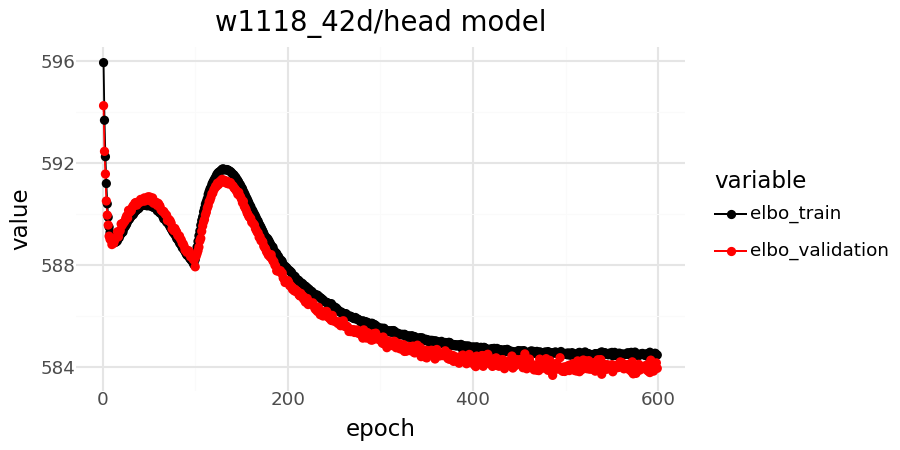

In [25]:
history_df = (
    w1118_42d_vae.history['elbo_train'].astype(float)
    .join(w1118_42d_vae.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 6, 3

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.ggtitle("w1118_42d/head model")
    + p.theme_minimal()
)


print(p_)

In [30]:
w1118_head_model = "/projectnb/mccall/sbandyadka/drpr42d_snrnaseq/analysis/scarches/w1118_head_model/"
w1118_42d_vae.save(outputpath, overwrite=True)
head_w1118_latent.write('head_w1118_latent.h5ad')

In [32]:
head_w1118_adata = fca_reference_head.concatenate(w1118_42d, batch_key="ref_query")
head_w1118_adata

/scratch/6077140.1.onrcc-gpu-pub/ipykernel_430265/588433526.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
/projectnb/mccall/sbandya/.conda/envs/drpr_snrnaseq_gpu/lib/python3.12/site-packages/anndata/_core/merge.py:1356: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.


AnnData object with n_obs × n_vars = 109560 × 2000
    obs: 'age', 'batch', 'batch_id', 'celda_decontx__clusters', 'celda_decontx__contamination', 'celda_decontx__doublemad_predicted_outliers', 'dissection_lab', 'fca_id', 'fly_genetics', 'id', 'log_n_counts', 'log_n_genes', 'n_counts', 'n_genes', 'note', 'percent_mito', 'sample_id', 'scrublet__doublet_scores', 'scrublet__predicted_doublets', 'scrublet__predicted_doublets_based_on_10x_chromium_spec', 'sex', 'tissue', 'leiden_res0.4', 'leiden_res0.6', 'leiden_res0.8', 'leiden_res1.0', 'leiden_res1.2', 'leiden_res1.4', 'leiden_res1.6', 'leiden_res1.8', 'leiden_res10.0', 'leiden_res12.0', 'leiden_res14.0', 'leiden_res16.0', 'leiden_res18.0', 'leiden_res2.0', 'leiden_res20.0', 'leiden_res25.0', 'leiden_res4.0', 'leiden_res50.0', 'leiden_res6.0', 'leiden_res8.0', 'annotation', 'broad_annotation', 'broad_annotation_extrapolated', 'orig.ident', 'nCount_originalexp', 'nFeature_originalexp', 'cell_barcode', 'column_name', 'sample', 'sum', 'detec

In [46]:
head_w1118_latent = sc.AnnData(w1118_42d_vae.get_latent_representation())
head_w1118_latent.obs["batch"] = w1118_42d.obs["batch"].tolist()
head_w1118_latent.obs["tissue"] = w1118_42d.obs["tissue"].tolist()
head_w1118_latent.obs["age"] = w1118_42d.obs["age"].tolist()
head_w1118_latent.obs["fly_genotype"] = w1118_42d.obs["fly_genotype"].tolist()

In [37]:
sc.pp.neighbors(head_w1118_latent)
sc.tl.leiden(head_w1118_latent)
sc.tl.umap(head_w1118_latent)

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:01:34)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:11)


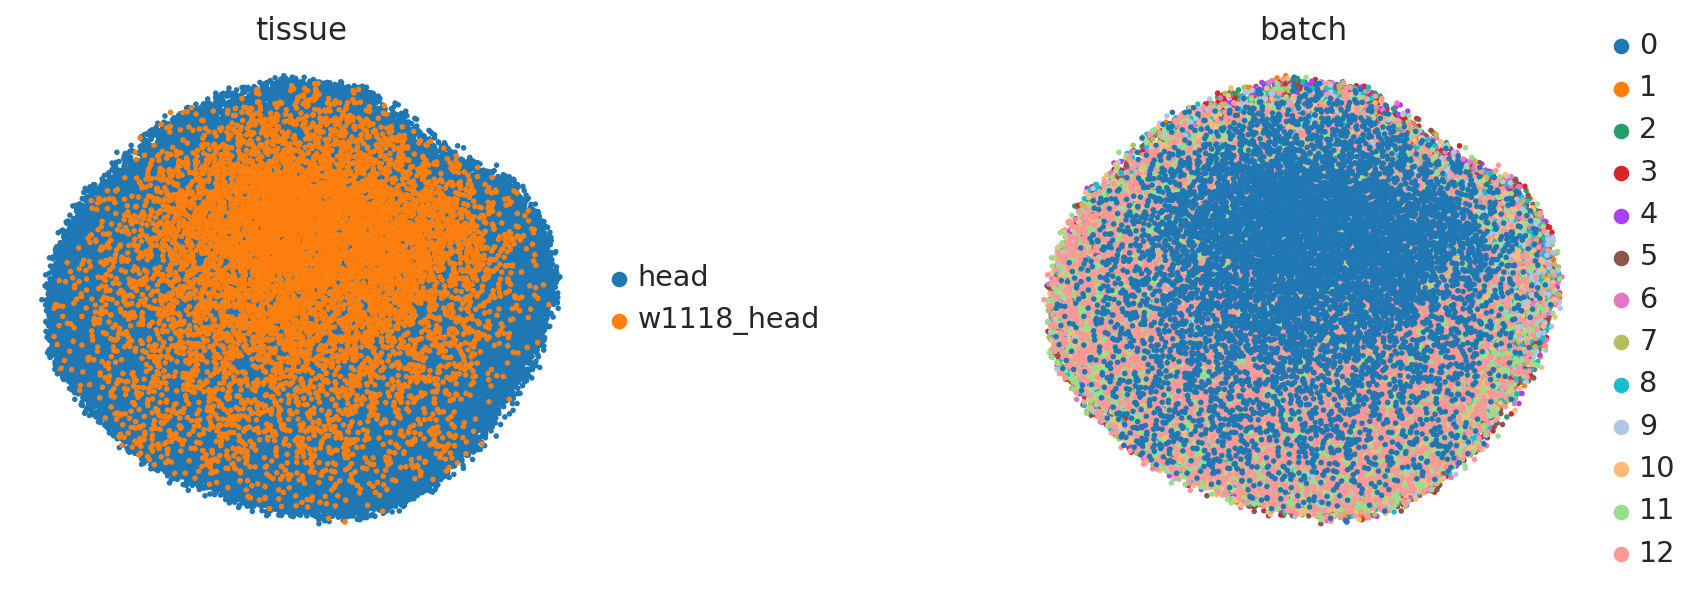

In [41]:
sc.pl.umap(head_w1118_latent,
           color=['tissue','batch'],
           frameon=False,
           wspace=0.6, s=25,
           #palette=sns.color_palette('colorblind', as_cmap=True)[:5],
           #save='study_query.pdf'
           )

In [43]:
query_pred_fullannotation = sca.classifiers.scHPL.predict_labels(head_w1118_latent.X, tree=tree_head_fullannotation_batch)
query_pred_braodannotation = sca.classifiers.scHPL.predict_labels(head_w1118_latent.X, tree=tree_head_broadannotation_batch)

In [44]:
w1118_42d.obs['predicted_fullannotation'] = query_pred_fullannotation[0]
w1118_42d.obs['predicted_broadannotation'] = query_pred_braodannotation[0]
sc.pp.neighbors(w1118_42d)
sc.tl.leiden(w1118_42d)
sc.tl.umap(w1118_42d)

ValueError: Length of values (109560) does not match length of index (9033)